PASO 1: Cargar y preparar los datos

In [1]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from math import *
import warnings
warnings.filterwarnings('ignore')

# Cargar y dividir los datos
df = pd.read_csv('/datasets/logs_exp_us.csv')
df_split = df.iloc[:, 0].str.split('\t', expand=True)
df_split.columns = ['event_name', 'user_id', 'event_timestamp', 'exp_group']
df = df_split

# Convertir tipos de datos
df['event_timestamp'] = df['event_timestamp'].astype(int)
df['event_time'] = pd.to_datetime(df['event_timestamp'], unit='s')
df['date'] = df['event_time'].dt.date
df['exp_group'] = df['exp_group'].astype(int)

print("✅ Datos cargados y preparados correctamente")
print(f"Shape: {df.shape}")
print(df.head())

✅ Datos cargados y preparados correctamente
Shape: (244126, 6)
                event_name              user_id  event_timestamp  exp_group  \
0         MainScreenAppear  4575588528974610257       1564029816        246   
1         MainScreenAppear  7416695313311560658       1564053102        246   
2  PaymentScreenSuccessful  3518123091307005509       1564054127        248   
3         CartScreenAppear  3518123091307005509       1564054127        248   
4  PaymentScreenSuccessful  6217807653094995999       1564055322        248   

           event_time        date  
0 2019-07-25 04:43:36  2019-07-25  
1 2019-07-25 11:11:42  2019-07-25  
2 2019-07-25 11:28:47  2019-07-25  
3 2019-07-25 11:28:47  2019-07-25  
4 2019-07-25 11:48:42  2019-07-25  


PASO 2: Verificar tipos de datos y valores ausentes

In [2]:
print("=== VERIFICACIÓN DE DATOS ===")
print("\n1. Tipos de datos:")
print(df.dtypes)

print("\n2. Valores nulos:")
print(df.isnull().sum())

print("\n3. Valores únicos por columna:")
print(f"Eventos: {df['event_name'].nunique()} -> {df['event_name'].unique()}")
print(f"Grupos experimentales: {df['exp_group'].unique()}")
print(f"Rango de fechas: {df['date'].min()} a {df['date'].max()}")

=== VERIFICACIÓN DE DATOS ===

1. Tipos de datos:
event_name                 object
user_id                    object
event_timestamp             int64
exp_group                   int64
event_time         datetime64[ns]
date                       object
dtype: object

2. Valores nulos:
event_name         0
user_id            0
event_timestamp    0
exp_group          0
event_time         0
date               0
dtype: int64

3. Valores únicos por columna:
Eventos: 5 -> ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
Grupos experimentales: [246 248 247]
Rango de fechas: 2019-07-25 a 2019-08-07


PASO 3: Análisis exploratorio y completitud de datos

=== ANÁLISIS EXPLORATORIO ===
1. Total de eventos: 244,126
2. Total de usuarios: 7,551
3. Promedio eventos por usuario: 32.33


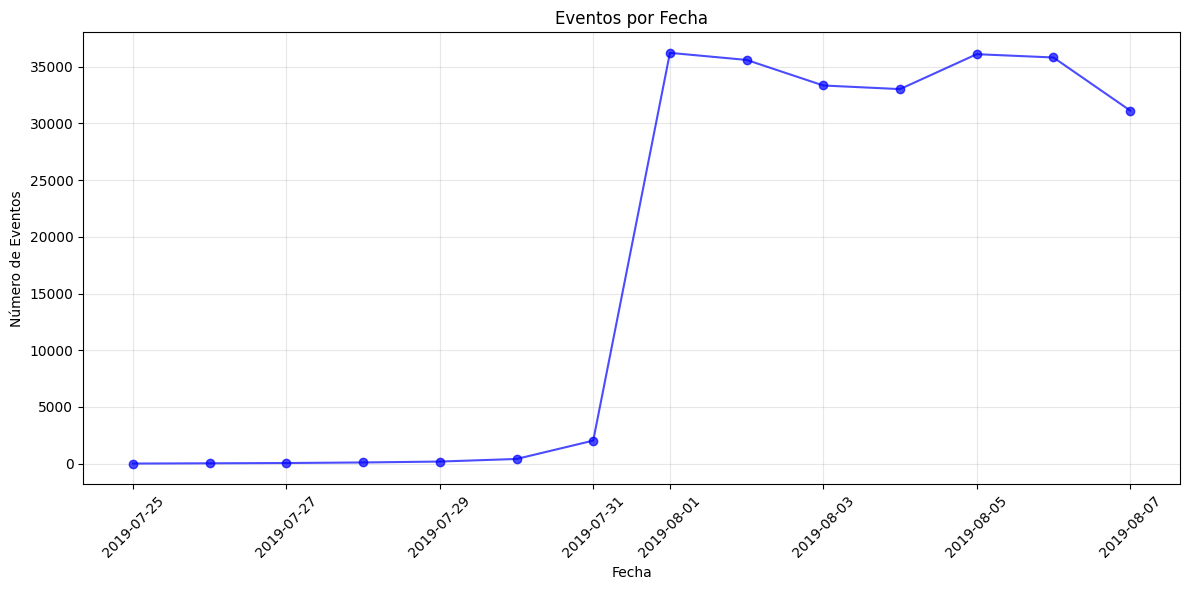


4. Rango completo: 2019-07-25 a 2019-08-07
Eventos por día:
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      413
2019-07-31     2031
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
Name: date, dtype: int64

5. Los datos se estabilizan a partir de: 2019-08-01

6. Pérdida por filtrado:
   Eventos perdidos: 2828 (1.16%)
   Usuarios perdidos: 17 (0.23%)

7. Distribución por grupo experimental (datos limpios):
246    79425
247    77147
248    84726
Name: exp_group, dtype: int64


In [3]:
print("=== ANÁLISIS EXPLORATORIO ===")

# 1. Métricas básicas
total_events = df.shape[0]
total_users = df['user_id'].nunique()
avg_events_per_user = total_events / total_users

print(f"1. Total de eventos: {total_events:,}")
print(f"2. Total de usuarios: {total_users:,}")
print(f"3. Promedio eventos por usuario: {avg_events_per_user:.2f}")

# 2. Histograma de eventos por fecha
plt.figure(figsize=(12, 6))
events_by_date = df['date'].value_counts().sort_index()
events_by_date.plot(kind='line', color='blue', alpha=0.7, marker='o')
plt.title('Eventos por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de Eventos')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Determinar cuándo los datos son completos
print(f"\n4. Rango completo: {df['date'].min()} a {df['date'].max()}")
print("Eventos por día:")
print(events_by_date)

# Encontrar cuando los datos se estabilizan
median_events = events_by_date.median()
stable_threshold = median_events * 0.8  # 80% de la mediana
stable_dates = events_by_date[events_by_date >= stable_threshold]
stable_start = stable_dates.index.min()

print(f"\n5. Los datos se estabilizan a partir de: {stable_start}")

# Filtrar datos estables
df_clean = df[df['date'] >= stable_start]

# 4. Verificar pérdida de datos
lost_events = total_events - df_clean.shape[0]
lost_users = total_users - df_clean['user_id'].nunique()

print(f"\n6. Pérdida por filtrado:")
print(f"   Eventos perdidos: {lost_events} ({lost_events/total_events*100:.2f}%)")
print(f"   Usuarios perdidos: {lost_users} ({lost_users/total_users*100:.2f}%)")

# 5. Verificar grupos experimentales
print(f"\n7. Distribución por grupo experimental (datos limpios):")
print(df_clean['exp_group'].value_counts().sort_index())

PASO 4: Estudiar el embudo de eventos

=== EMBUDO DE EVENTOS ===
1. Frecuencia de eventos:
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event_name, dtype: int64

2. Usuarios únicos por evento:
event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

3. Proporción de usuarios por evento:
event_name
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: user_id, dtype: float64

4. Embudo definido: MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful

5. Conversión entre etapas:
   MainScreenAppear: 7,419 usuarios (98.5% del total)
   OffersScreenAppear: 4,593 usuarios | Conversión: 61.9% | Pérdida: 

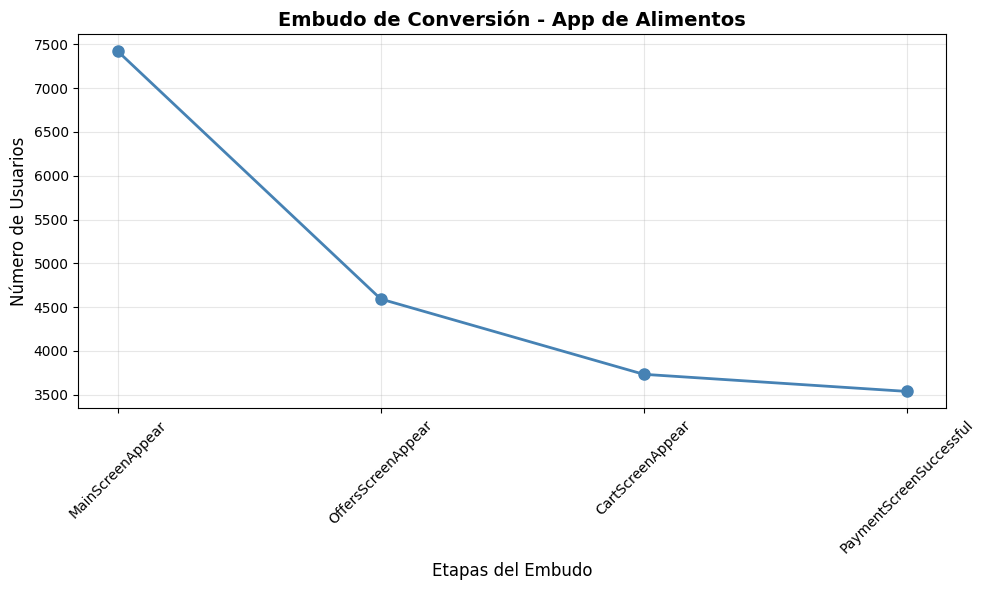


6. Mayor pérdida: MainScreenAppear → OffersScreenAppear
   Conversión: 61.9%

7. Usuarios que completan TODO el journey: 47.70%
   De 7,419 a 3,539 usuarios


In [4]:
print("=== EMBUDO DE EVENTOS ===")

# 1. Frecuencia de eventos
event_frequency = df_clean['event_name'].value_counts()
print("1. Frecuencia de eventos:")
print(event_frequency)

# 2. Usuarios únicos por evento
users_per_event = df_clean.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
print("\n2. Usuarios únicos por evento:")
print(users_per_event)

# 3. Proporción de usuarios por evento
total_users_clean = df_clean['user_id'].nunique()
proportion_per_event = users_per_event / total_users_clean
print("\n3. Proporción de usuarios por evento:")
print(proportion_per_event)

# 4. Definir secuencia del embudo (basado en la lógica de la app)
funnel_steps = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
print(f"\n4. Embudo definido: {' → '.join(funnel_steps)}")

# 5. Calcular conversión entre etapas
funnel_data = []
conversion_rates = []

print("\n5. Conversión entre etapas:")
for i, step in enumerate(funnel_steps):
    users_at_step = df_clean[df_clean['event_name'] == step]['user_id'].nunique()
    funnel_data.append(users_at_step)
    
    if i == 0:
        print(f"   {step}: {users_at_step:,} usuarios ({users_at_step/total_users_clean*100:.1f}% del total)")
    else:
        conversion_rate = users_at_step / funnel_data[i-1] * 100
        conversion_rates.append(conversion_rate)
        loss_rate = 100 - conversion_rate
        print(f"   {step}: {users_at_step:,} usuarios | Conversión: {conversion_rate:.1f}% | Pérdida: {loss_rate:.1f}%")

# 6. Visualizar el embudo
plt.figure(figsize=(10, 6))
plt.plot(funnel_steps, funnel_data, marker='o', linewidth=2, markersize=8, color='steelblue')
plt.title('Embudo de Conversión - App de Alimentos', fontsize=14, fontweight='bold')
plt.xlabel('Etapas del Embudo', fontsize=12)
plt.ylabel('Número de Usuarios', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Encontrar la etapa con mayor pérdida
if conversion_rates:
    max_loss_index = conversion_rates.index(min(conversion_rates))
    print(f"\n6. Mayor pérdida: {funnel_steps[max_loss_index]} → {funnel_steps[max_loss_index+1]}")
    print(f"   Conversión: {conversion_rates[max_loss_index]:.1f}%")

# 8. Porcentaje de usuarios que completan todo el journey
final_conversion = funnel_data[-1] / funnel_data[0] * 100
print(f"\n7. Usuarios que completan TODO el journey: {final_conversion:.2f}%")
print(f"   De {funnel_data[0]:,} a {funnel_data[-1]:,} usuarios")

PASO 5: Análisis del experimento A/A/B

In [5]:
print("=== EXPERIMENTO A/A/B ===")

# 1. Función para test de hipótesis
def hypothesis_test(group1, group2, event, alpha=0.1):
    """Realiza test de proporciones para dos grupos"""
    # Usuarios únicos en cada grupo
    users_group1 = group1['user_id'].nunique()
    users_group2 = group2['user_id'].nunique()
    
    # Usuarios que realizaron el evento
    event_users_group1 = group1[group1['event_name'] == event]['user_id'].nunique()
    event_users_group2 = group2[group2['event_name'] == event]['user_id'].nunique()
    
    # Proporciones
    p1 = event_users_group1 / users_group1
    p2 = event_users_group2 / users_group2
    
    # Proporción combinada
    p_combined = (event_users_group1 + event_users_group2) / (users_group1 + users_group2)
    
    # Diferencia
    diff = p1 - p2
    
    # Estadístico Z
    se = sqrt(p_combined * (1 - p_combined) * (1/users_group1 + 1/users_group2))
    z = diff / se if se != 0 else 0
    
    # Valor p (two-tailed)
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return p_value, p1, p2, diff

# 2. Separar grupos
group_246 = df_clean[df_clean['exp_group'] == 246]
group_247 = df_clean[df_clean['exp_group'] == 247]
group_248 = df_clean[df_clean['exp_group'] == 248]

print("1. Tamaño de los grupos:")
print(f"   Grupo 246 (control 1): {group_246['user_id'].nunique():,} usuarios")
print(f"   Grupo 247 (control 2): {group_247['user_id'].nunique():,} usuarios")
print(f"   Grupo 248 (prueba): {group_248['user_id'].nunique():,} usuarios")

# 3. Test A/A (grupos de control)
print("\n2. TEST A/A - Grupos 246 vs 247 (deberían ser similares):")
events_to_test = df_clean['event_name'].unique()
significant_aa = 0

for event in events_to_test:
    p_value, p1, p2, diff = hypothesis_test(group_246, group_247, event)
    is_significant = p_value < 0.1
    if is_significant:
        significant_aa += 1
    
    print(f"   {event:25} p-value: {p_value:.4f} | 246: {p1:.4f} | 247: {p2:.4f} | Diff: {diff:.4f} {'⚠️' if is_significant else '✅'}")

print(f"\n   {significant_aa}/{len(events_to_test)} eventos mostraron diferencias significativas en A/A")

# 4. Test A/B (grupo experimental vs controles combinados)
print("\n3. TEST A/B - Grupo 248 vs Controles Combinados:")
control_combined = pd.concat([group_246, group_247])
significant_ab = 0

for event in events_to_test:
    p_value, p_control, p_test, diff = hypothesis_test(control_combined, group_248, event)
    is_significant = p_value < 0.1
    if is_significant:
        significant_ab += 1
    
    effect = "🟢 MEJORA" if p_test > p_control else "🔴 EMPEORA" if is_significant else "➡️ SIN CAMBIO"
    print(f"   {event:25} p-value: {p_value:.4f} | Control: {p_control:.4f} | Test: {p_test:.4f} | {effect}")

print(f"\n   {significant_ab}/{len(events_to_test)} eventos mostraron diferencias significativas en A/B")

# 5. Corrección por múltiples comparaciones
print("\n4. CORRECCIÓN POR MÚLTIPLES COMPARACIONES:")
n_tests = len(events_to_test)
alpha_bonferroni = 0.1 / n_tests

print(f"   Número de pruebas: {n_tests}")
print(f"   Alpha original: 0.1")
print(f"   Alpha Bonferroni: {alpha_bonferroni:.4f}")

# Re-evaluar con corrección
print("\n5. RESULTADOS CON CORRECCIÓN BONFERRONI:")
significant_ab_corrected = 0

for event in events_to_test:
    p_value, p_control, p_test, diff = hypothesis_test(control_combined, group_248, event)
    is_significant = p_value < alpha_bonferroni
    
    if is_significant:
        significant_ab_corrected += 1
        effect = "🟢 MEJORA SIGNIFICATIVA" if p_test > p_control else "🔴 EMPEORA SIGNIFICATIVAMENTE"
        print(f"   {event:25} {effect} (p-value: {p_value:.4f})")

print(f"\n   {significant_ab_corrected}/{len(events_to_test)} eventos significativos después de corrección")

=== EXPERIMENTO A/A/B ===
1. Tamaño de los grupos:
   Grupo 246 (control 1): 2,484 usuarios
   Grupo 247 (control 2): 2,513 usuarios
   Grupo 248 (prueba): 2,537 usuarios

2. TEST A/A - Grupos 246 vs 247 (deberían ser similares):
   Tutorial                  p-value: 0.9377 | 246: 0.1119 | 247: 0.1126 | Diff: -0.0007 ✅
   MainScreenAppear          p-value: 0.7571 | 246: 0.9863 | 247: 0.9853 | Diff: 0.0010 ✅
   OffersScreenAppear        p-value: 0.2481 | 246: 0.6208 | 247: 0.6049 | Diff: 0.0159 ✅
   CartScreenAppear          p-value: 0.2288 | 246: 0.5097 | 247: 0.4926 | Diff: 0.0170 ✅
   PaymentScreenSuccessful   p-value: 0.1146 | 246: 0.4831 | 247: 0.4608 | Diff: 0.0223 ✅

   0/5 eventos mostraron diferencias significativas en A/A

3. TEST A/B - Grupo 248 vs Controles Combinados:
   Tutorial                  p-value: 0.7649 | Control: 0.1123 | Test: 0.1100 | ➡️ SIN CAMBIO
   MainScreenAppear          p-value: 0.2942 | Control: 0.9858 | Test: 0.9827 | ➡️ SIN CAMBIO
   OffersScreenAppear

PASO 6: Conclusiones finales

In [6]:
print("=== CONCLUSIONES FINALES ===")

print("1. EMBUDO DE VENTAS:")
print(f"   - Mayor pérdida en: {funnel_steps[max_loss_index]} → {funnel_steps[max_loss_index+1]} ({conversion_rates[max_loss_index]:.1f}% conversión)")
print(f"   - Solo {final_conversion:.2f}% de usuarios completan todo el journey")

print("\n2. EXPERIMENTO A/A/B:")
print(f"   - Test A/A: {significant_aa}/{len(events_to_test)} eventos con diferencias (esperábamos 0-1)")
print(f"   - Test A/B: {significant_ab_corrected}/{len(events_to_test)} eventos con diferencias significativas después de corrección")

if significant_ab_corrected == 0:
    print("   ✅ RECOMENDACIÓN: Las nuevas fuentes NO afectan significativamente el comportamiento del usuario")
    print("   Pueden implementarse las nuevas fuentes sin riesgo")
else:
    print("   ⚠️  RECOMENDACIÓN: Las nuevas fuentes SI afectan el comportamiento del usuario")
    print("   Se necesita más análisis antes de implementar")

print("\n3. METRICA CLAVE:")
print(f"   - Tasa de conversión final: {final_conversion:.2f}%")
print(f"   - Usuarios que llegan a pago: {funnel_data[-1]:,} de {funnel_data[0]:,}")

=== CONCLUSIONES FINALES ===
1. EMBUDO DE VENTAS:
   - Mayor pérdida en: MainScreenAppear → OffersScreenAppear (61.9% conversión)
   - Solo 47.70% de usuarios completan todo el journey

2. EXPERIMENTO A/A/B:
   - Test A/A: 0/5 eventos con diferencias (esperábamos 0-1)
   - Test A/B: 0/5 eventos con diferencias significativas después de corrección
   ✅ RECOMENDACIÓN: Las nuevas fuentes NO afectan significativamente el comportamiento del usuario
   Pueden implementarse las nuevas fuentes sin riesgo

3. METRICA CLAVE:
   - Tasa de conversión final: 47.70%
   - Usuarios que llegan a pago: 3,539 de 7,419
